<center> <font size = 7 color = 'steelblue'> <b> Reinforcement Learning With Deep Q Network: 
<center> <font size = 7 color = 'steelblue'> <b>Solving CartPole-v1 Problem

<div class="alert alert-block alert-success"> 
<font size = 5> 
    
Welcome to this practical notebook on reinforcement learning! 
- This exercise is designed to provide hands-on experience with Deep Q-Networks (DQN) by tackling the **CartPole-v1** problem from the OpenAI Gym toolkit. 
- The goal is to provide an intuitive understanding of reinforcement learning concepts, the architecture of DQNs, and how they can be applied to solve complex problems.

<font size = 6 color = 'midnightblue'> <b> What Is Reinforcement Learning?

<div class="alert alert-block alert-success"> 
<font size = 4> 
    
- Reinforcement Learning (RL) is a type of machine learning where an agent learns to make decisions by taking actions in an environment to achieve some notion of cumulative reward. 
- The agent learns from the consequences of its actions, rather than from being told explicitly what to do, essentially learning by trial and error.

<font size = 6 color = 'midnightblue'> <b> Deep Q-Networks (DQN)

<div class="alert alert-block alert-success"> 
<font size = 4> 
    
- Deep Q-Networks combine Q-Learning with deep neural networks to let agents learn how to act optimally in discrete action spaces. 
- They use a neural network to approximate the optimal action-value function, which represents the maximum sum of rewards an agent can expect to obtain, starting from a state and taking an optimal action sequence thereafter.

<font size = 6 color = 'midnightblue'> <b> The CartPole-v1 Problem

<div class="alert alert-block alert-success"> 
<font size = 4> 
    
- In the **CartPole-v1** problem, a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. 
- The system is controlled by applying a force of +1 or -1 to the cart. 
- The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.

<font size = 6 color = 'midnightblue'> <b>  Objectives

<div class="alert alert-block alert-info"> 
<font size = 4> 

**By the end of this notebook, you will**

- Implement a DQN to solve the CartPole-v1 problem using the OpenAI Gym environment.

<font size = 6 color = 'seagreen'> <b>Setup

In [ ]:
pip install gym==0.25.2

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)



# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [2]:
import gym

<font size = 6 color = 'midnightblue'> <b> Setting Up the Deep Q-Network (DQN) Model

<div class="alert alert-block alert-success"> 
<font size = 4> 

**In this section of the notebook:**

- Initialize our Deep Q-Network (DQN) model to solve the CartPole-v1 problem. 

<b>Here's a breakdown of what each part of the code is doing:</b>

1. **Clearing the Session and Setting Seeds:**

    ```python
    keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)
    ```
<br>

- `keras.backend.clear_session()`: 
    - Clears any existing model in memory, ensuring that the model about to be created is fresh and unimpacted by previous models.
- `tf.random.set_seed(42) & np.random.seed(42)`: 
    - These lines set the seed for random number generation in TensorFlow and NumPy, respectively. 
    - Setting a seed ensures that our model's random weight initialization and other random processes are reproducible.

2. **Initializing the Environment:**

    ```python
    env = gym.make("CartPole-v1")
    input_shape = [4] # == env.observation_space.shape
    n_outputs = 2 # == env.action_space.n
    ```
<br>
    
- `env = gym.make("CartPole-v1")`: Creates an instance of the CartPole-v1 environment using OpenAI's Gym toolkit. This environment will be used to train and evaluate our DQN.
- `input_shape = [4]`: Defines the shape of the input to our neural network, corresponding to the observation space of the environment (position, velocity, angle, rotation rate).
- `n_outputs = 2`: The number of outputs our network will have, corresponding to the number of possible actions (move left or move right) in the CartPole game.

3. **Constructing the Neural Network Model:**

    ```python
    model = keras.models.Sequential([
        keras.layers.Dense(32, activation="elu", input_shape=input_shape),
        keras.layers.Dense(32, activation="elu"),
        keras.layers.Dense(n_outputs)
    ])
    ```
<br>
    
- `keras.models.Sequential()`: This initializes a sequential model, indicating that each layer added next will feed directly into the layer that follows it.
- `keras.layers.Dense(32, activation="elu", input_shape=input_shape)`: The first dense layer with 32 neurons and `elu` (Exponential Linear Unit) activation function. It is the input layer and expects data in the shape of the environment's observation space.
- `keras.layers.Dense(32, activation="elu")`: The second dense layer, also with 32 neurons and using the `elu` activation function.
- `keras.layers.Dense(n_outputs)`: The output layer with a number of neurons equal to the number of possible actions. It does not use an activation function as it will output the raw scores for each action, which are then interpreted by the DQN to make a decision.

<div class="alert alert-block alert-info"> 
<font size = 4> 

**In summary,**
    
- A DQN is setup with a simple neural network architecture, ensuring reproducibility, and configuring it to work with the CartPole-v1 environment.
- This setup will be the foundation for training the agent to balance the pole on the cart by deciding to move left or right at each time step.

In [3]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

env = gym.make("CartPole-v1")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


<div class="alert alert-block alert-success"> 
<font size = 4> 
    
**To select an action using this DQN,**
- Pick the action with the largest predicted Q-value. 
- However, to ensure that the agent explores the environment, a random action with probability epsilon is chosen.

<div class="alert alert-block alert-success"> 
<font size = 4> 
    
The `epsilon_greedy_policy` function is a strategy for the agent to choose its next action based on the current state. It is a fundamental part of the Deep Q-Network (DQN) algorithm used in training the agent to solve the **CartPole-v1** problem. 

**Here's how it works:**

- **Epsilon-Greedy Strategy**: 
    - This method balances exploration and exploitation by choosing between exploring a random action or exploiting the best known action. 
    - The balance is controlled by the parameter `epsilon`, representing the probability of taking a random action.

- **Parameters**:
  - `state`: This represents the current state of the environment that the agent observes.
  - `epsilon`: This is a value between 0 and 1 determining how often the agent explores. A higher epsilon increases the likelihood of taking a random action.

- **Functionality**:
  - **Exploration**: 
    - With probability `epsilon`, the function returns a random action. 
    - This encourages the agent to explore the environment and learn about the rewards of different actions it might not have tried yet.
  - **Exploitation**: 
    - With probability `1 - epsilon`, the function predicts the Q-values for the current state using the model and chooses the action with the highest Q-value. 
    - This represents the best-known action based on the current policy and encourages the agent to exploit its knowledge to gain higher rewards.

- **Q-values**: These are predictions from the neural network model representing the expected rewards for taking each action in the given state. The action with the highest Q-value is considered the best according to the current policy.

<div class="alert alert-block alert-info"> 
<font size = 4>
  <b>  
      
---
      
In summary, 

- The `epsilon_greedy_policy` function is a decision-making strategy used in DQN where the agent decides between exploring the environment randomly or exploiting its knowledge based on the learned Q-values. 
- It's a critical component in balancing exploration with exploitation, allowing the agent to learn effectively over time.
      
---

In [1]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

<div class="alert alert-block alert-success"> 
<font size = 4>  
      
<b> 

The given code snippet is setting up a replay memory for a Deep Q-Network (DQN) algorithm, which is a common strategy in reinforcement learning for stabilizing and improving the training process:

- **`from collections import deque`**: 
    - This line imports the `deque` class from the `collections` module. 
    - A deque (double-ended queue) is a data structure that allows fast appends and pops from both ends.

- **`replay_memory = deque(maxlen=2000)`**: 
    - This line initializes `replay_memory` as an instance of a deque with a maximum length of 2000.
    - This means it will hold the last 2000 experiences (state, action, reward, next state) encountered by the agent in the environment.

<font size = 6 color = 'midnightblue'> <b>  Purpose and Functionality of Replay Memory:

<div class="alert alert-block alert-success"> 
<font size = 4> 
    
- **Storing Experiences**: Replay memory is used to store the experiences of the agent as it interacts with the environment. Each experience typically includes the state, the action taken, the reward received, and the next state.
- **Sample for Training**: Instead of using just the most recent experience to train the model, the agent randomly samples a batch of experiences from the replay memory. This helps break the correlation between consecutive samples and leads to more stable and efficient learning.
- **Max Length**: Setting a maximum length ensures that the memory does not grow indefinitely. It holds a fixed number of the most recent experiences, which means older experiences are discarded. This is important for both memory management and ensuring the relevance of the training data.

<div class="alert alert-block alert-info"> 
<font size = 4>
  <b>  
      
---
In summary, 
- `replay_memory` is a crucial component in DQN algorithms, allowing the agent to remember and learn from past experiences effectively. 
- It helps in smoothing out the training process and improving the stability and performance of the neural network model.
---

In [5]:
from collections import deque

replay_memory = deque(maxlen=2000)

<div class="alert alert-block alert-success"> 
<font size = 4> 
    
The `sample_experiences` function is a component of the Deep Q-Network (DQN) training process, specifically related to the experience replay mechanism. 
    
**Here's a breakdown of its purpose and functionality:**

- **Purpose**: 
    - The function is designed to sample a random batch of experiences from the replay memory. 
    - This is a key part of the DQN algorithm, where the model is trained on a random subset of past experiences, rather than the most recent transition. 
    - This approach helps to reduce the correlation between consecutive training samples and leads to more stable and effective learning.

- **Parameters**:
    - `batch_size` is the number of experiences to sample from the replay memory. 
    - This defines how many experiences will be used in each training update of the DQN.

- **Functionality**:
  1. **Random Sampling**: The function first randomly selects indices corresponding to the positions in the replay memory. The number of indices is determined by the `batch_size`.
  2. **Batch Creation**: It then constructs the batch by retrieving the experiences at these indices. Each experience typically includes the state, action, reward, next state, and a done flag indicating whether the episode has ended.
  3. **Structure Conversion**: The experiences are structured into separate arrays for states, actions, rewards, next states, and dones. Each array contains the corresponding elements from all experiences in the batch.
  4. **Return Value**: Finally, the function returns these arrays, providing a convenient format for feeding the data into the neural network during the training step.


In [6]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

<div class="alert alert-block alert-success"> 
<font size = 4>
    
The `play_one_step` function is a key component of the reinforcement learning loop in the context of training a Deep Q-Network (DQN). 
    
**Here's a brief explanation:**

- **Purpose**: This function encapsulates the logic for the agent taking a single step in the environment. It decides on an action, observes the outcome, and stores the experience.

- **Functionality**:
  1. **Action Selection**: It uses the `epsilon_greedy_policy` to choose an action based on the current state and epsilon value. This method balances exploration (trying new actions) and exploitation (using the best-known action).
  2. **Environment Interaction**: The chosen action is then applied to the environment using `env.step`, which returns the next state, reward, and done flag (indicating whether the episode has ended).
  3. **Memory Update**: The experience (current state, action, reward, next state, and done status) is appended to the `replay_memory`, allowing the agent to learn from it later during training.
  4. **Return Value**: Finally, the function returns the next state, reward, done flag, and additional info from the environment step.

<div class="alert alert-block alert-info"> 
<font size = 4>
  <b>  
      
---
In summary, 
- `play_one_step` is responsible for the agent's interaction with the environment at each step, collecting experiences for future learning while progressing through an episode.
    
---

In [7]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

<div class="alert alert-block alert-success"> 
<font size = 4>
    
The `training_step` function is an integral part of training a Deep Q-Network (DQN) for reinforcement learning. 
    
**Here's a brief overview:**

- **Purpose**: 
    - It performs a single update step on the model by processing a batch of experiences from the replay memory. 
    - The function calculates the loss between predicted Q-values and the target Q-values and updates the model's weights to minimize this loss.

    <br>
    
- **Functionality**:
    - **Sampling Experiences**: It starts by sampling a batch of experiences using the `sample_experiences` function.
    - **Predicting Next Q-Values**: The function predicts the Q-values for the next states and calculates the maximum Q-value for each next state, representing the best possible future reward.
    - **Calculating Target Q-Values**: The target Q-values are calculated based on the rewards from the batch and the discounted max next Q-values, adjusted for whether the episode has ended.
    - **Updating the Model**: With the target Q-values, the function calculates the loss using the specified loss function. It then computes gradients and applies them to the model's weights using the Adam optimizer.
    
    <br>

- **Parameters**: 
    - It uses several predefined variables like `batch_size`, `discount_rate`, `optimizer`, and `loss_fn`, which control various aspects of the training process.

<div class="alert alert-block alert-info"> 
<font size = 4>
  <b>  
  
---
      
In summary, 
- `training_step` is a function that updates the DQN model by training it on a sample of experiences, using the predicted and target Q-values to improve the policy through gradient descent.

---

In [8]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

<div class="alert alert-block alert-success"> 
<font size = 5>
  <b>  
      <center>And now, let's train the model!

In [10]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


<div class="alert alert-block alert-success"> 
<font size = 4>
      
This code represents the main training loop for an agent playing the **CartPole-v1** environment using a DQN strategy. 
      
**Here's a brief overview of its functionality:**

- **Episode Loop**: 
    - The loop runs for a predefined number of episodes (600). 
    - Each episode represents a full game run, from start to finish or until a maximum number of steps (200) is reached.

- **Exploration Factor (Epsilon)**: 
    - For each episode, it adjusts the `epsilon` value used in the `epsilon_greedy_policy`. 
    - Epsilon starts high for more exploration and decays over time, ensuring that the agent gradually shifts from exploring the environment to exploiting its learned knowledge.

- **Playing Steps**: 
    - Within each episode, the loop calls `play_one_step`, which takes an action in the environment and stores the result in replay memory. 
    - The loop continues until the episode is done (i.e., the pole falls down, or the step limit is reached).

- **Tracking Performance**: 
    - The loop tracks the number of steps the agent survived in each episode and updates the best score and best weights seen so far. 
    - This helps in capturing the most effective policy during the training.

- **Training**: 
    - After the initial 50 episodes, it calls `training_step` with the current batch size to update the model weights using a batch of experiences sampled from the replay memory.

- **Setting Best Weights**: 
    - After all episodes are completed, it sets the model weights to the best weights observed during training.

<div class="alert alert-block alert-info"> 
<font size = 4>
  <b>  
  
---
In summary,
- This loop represents the entire training process for a DQN agent, involving exploration, exploitation, and continuous learning from the environment. 
- The agent aims to maximize its performance in the given task, adjusting its strategy based on the observed rewards and updating its policy network accordingly.

---

In [11]:
for episode in range(600):
    obs = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

1/1 [==============================] - 0s 35ms/step


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step


Saving figure dqn_rewards_plot


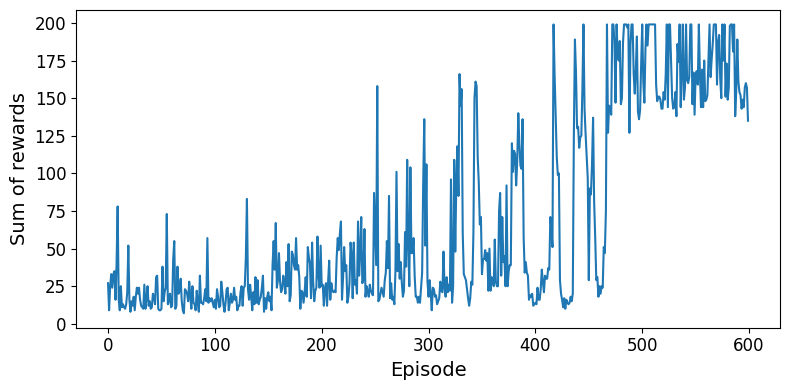

In [12]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("dqn_rewards_plot")
plt.show()

In [16]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)

plot_animation(frames)

1/1 [==============================] - 0s 19ms/step
